# Attention (Lecture 14)

在没有注意力机制时，写作员只能依靠阅读员给他的**一份最终摘要 (`c`)** 来翻译整个句子。对于长句子来说，这份摘要的信息量根本不够。有了注意力机制，写作员不再依赖那份固定的摘要。在他准备写**每一个**中文词之前，他都会根据所标出当前最需要关注的部分，生成一份**全新的、为当前步骤量身定制的动态摘要**。

## 具体实现

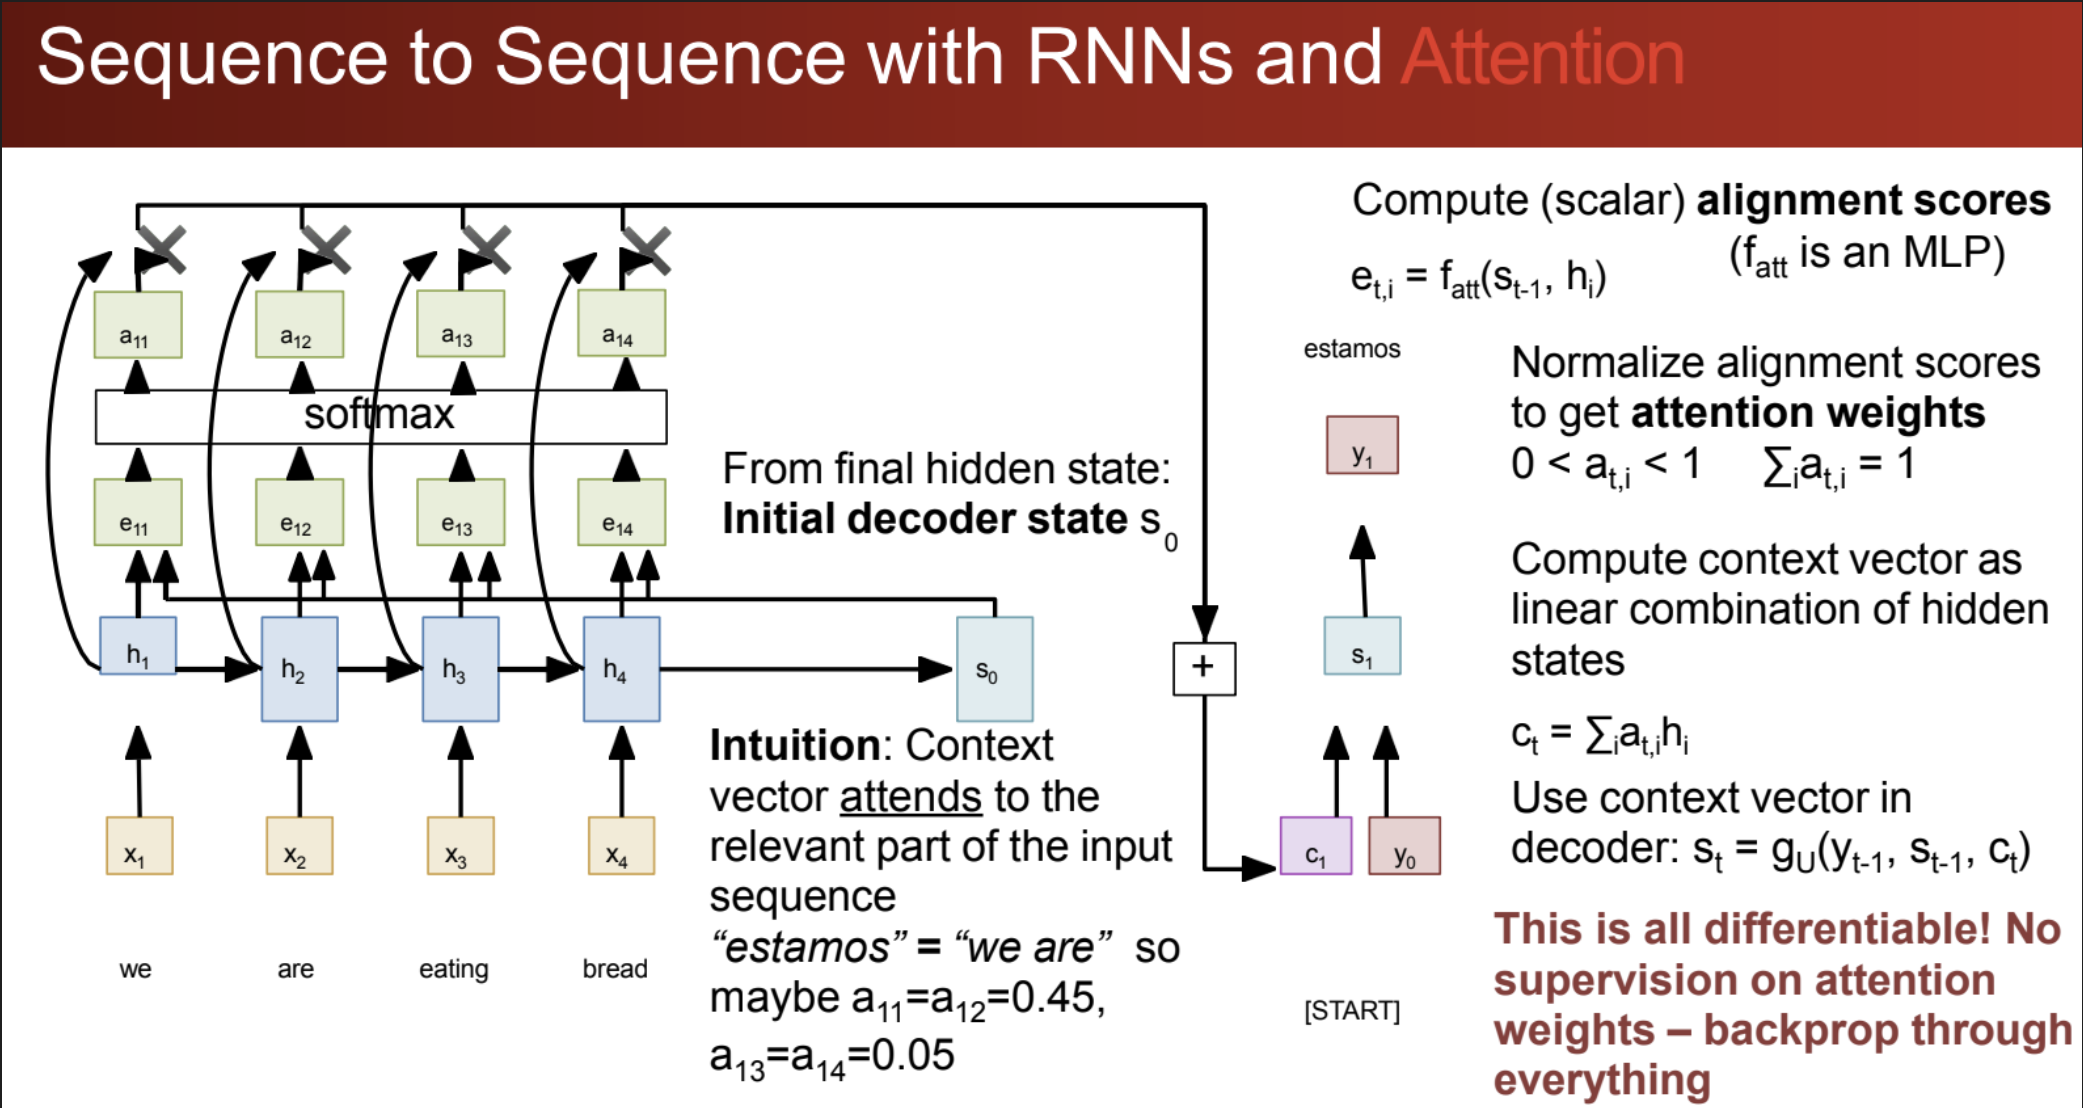

### **第1步：计算相关性**

*   **目的 (作用):** 判断原文中每个词（"we", "are", "eating", "bread"）对于**即将要生成的第一个西班牙语单词**有多重要。
*   **实现 (怎么做):**
    *   模型将解码器的当前思路 `s₀` 和原文中**每一个词的摘要**（`h₁`, `h₂`, `h₃`, `h₄`）分别进行一次“匹配度计算”。这个计算由一个小型神经网络 `f_att` 完成。
    *   `e₁₁ = f_att(s₀, h₁)`  => `s₀` 和 "we" 的相关性得分
    *   `e₁₂ = f_att(s₀, h₂)`  => `s₀` 和 "are" 的相关性得分
    *   ...以此类推，得到四个**对齐分数 (alignment scores)** `e₁₁`, `e₁₂`, `e₁₃`, `e₁₄`。
    *   这里的 `e` 就代表这个原始的、未经处理的“分数”。分数越高，代表相关性越强。

### **第2步：分配注意力**

*   **目的 (作用):** 将刚才得到的原始分数，转换成一个清晰的“注意力百分比”分布。
*   **实现 (怎么做):**
    *   使用 **Softmax** 函数。能把一组任意数值（比如 `[1.2, 1.5, 0.1, 0.3]`）转换成一组总和为1的概率值（比如 `[0.45, 0.45, 0.05, 0.05]`）。
    *   输出的 `a₁₁`, `a₁₂`, `a₁₃`, `a₁₄` 就是**注意力权重 (attention weights)**。

### **第3步：生成动态摘要**

*   **目的 (作用):** 根据刚刚分配好的注意力权重，生成一个**为当前步骤量身定制的上下文向量 `c₁`**。
*   **实现 (怎么做):**
    *   对原文所有词的摘要 (`h₁` 到 `h₄`) 进行**加权求和**。
    *   `c₁ = a₁₁*h₁ + a₁₂*h₂ + a₁₃*h₃ + a₁₄*h₄`
    *   由于 `a₁₁` 和 `a₁₂` 很大，而 `a₁₃` 和 `a₁₄` 很小，所以这个新的上下文向量 `c₁` 的内容，**绝大部分都来自于 `h₁` ("we") 和 `h₂` ("are")**。它是一个专门为翻译 "we are" 而定制的摘要。

### **第4步：生成翻译词**

*   **实现 (怎么做):**
    *   解码器RNN接收三个输入：上一步的思路 `s₀`，上一步生成的词 `y₀` ([START]信号)，以及我们刚计算出的**动态上下文向量 `c₁`**。
    *   通过 `s₁ = g_U(y₀, s₀, c₁)` 计算出新的思路 `s₁`。
    *   最后，`s₁` 经过Softmax层，预测出概率最高的词是 "estamos"，也就是 `y₁`。

### **BP**
整个注意力计算过程（打分、Softmax、加权求和）都是可微分的数学运算。这意味着我们可以用反向传播 (backprop) 来训练整个系统。


# 缩放点积注意力（Scaled Dot-Product Attention）

将前面介绍的“注意力机制”从一个具体应用（用在RNN里）**抽象和泛化**成一个独立的、可重用的神经网络层，即**注意力层（Attention Layer）**。

## 具体实现过程

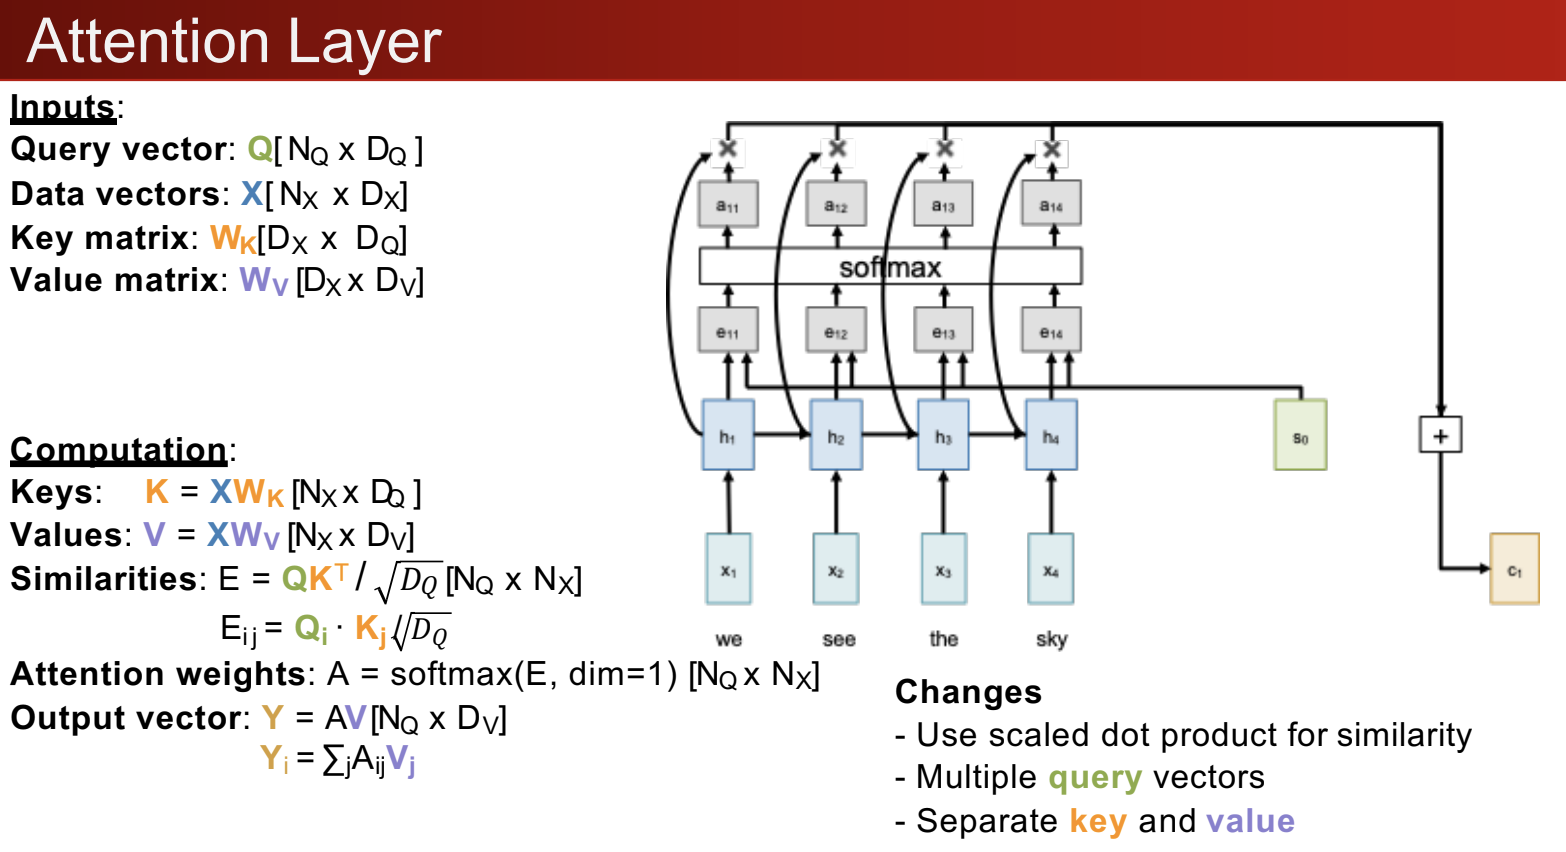

### 1. 输入 (Inputs)：注意力层的“原料”

这部分定义了我们需要准备哪些东西来启动这个“信息检索”过程。

*   `Query vector: Q`: **查询向量**。
    *   **含义**：代表着“我们想问什么”或“我们当前关注的焦点是什么”。
    *   **维度**：`[NQ x DQ]` 表示我们有 `NQ` 个问题，每个问题的向量表示维度是 `DQ`。

*   `Data vectors: X`: **数据向量**。
    *   **含义**：这是我们的“信息源”，也就是那一大堆待查询的资料。
    *   **维度**：`[Nx x Dx]` 表示我们有 `Nx` 份资料，每份资料的向量表示维度是 `Dx`。

*   `Key matrix: Wk` 和 `Value matrix: Wv`: **键矩阵** 和 **值矩阵**。
    *   **含义**：这是两个**可以学习的**权重矩阵。它们的作用是把原始的“数据向量 `X`” 转换成两种不同的角色：**键（Keys）** 和 **值（Values）**。
    *   **类比**：
        *   **键（Keys）**：每本书的**“索引”或“标题”**。它是为了方便和你的问题（Query）进行快速匹配。
        *   **值（Values）**：每本书的**“具体内容”**。一旦你通过标题找到了相关的书，你真正想要的是书里面的内容。
    *   **关键点**：把信息源（X）分成“用于匹配的索引（Key）”和“用于提取的内容（Value）”是这个机制的核心。这让模型更加灵活。

---

### 2. 计算 (Computation)：注意力层的“处理流程”

这部分是核心，详细说明了如何用上面的原料，一步步计算出最终结果。

#### 第1步: 生成“键”和“值” (Keys and Values)

我们用 `Wk` 和 `Wv` 两个矩阵，把原始数据 `X` 投影成 `K` 和 `V`。

*   `Keys: K = X * Wk`: 
    *   **公式**: $K = XW_K$
    *   **含义**: 将所有原始数据 `X` 转换成它们的“索引”版本 `K`。

*   `Values: V = X * Wv`:
    *   **公式**: $V = XW_V$
    *   **含义**: 将所有原始数据 `X` 转换成它们的“内容”版本 `V`。

#### 第2步: 计算相似度 (Similarities)

现在，我们要用我们的问题 `Q` 去和所有资料的“索引” `K` 进行匹配，看看哪个更相关。

*   `Similarities: E = ...`:
    *   **公式**: $E = \frac{QK^T}{\sqrt{D_Q}}$
    *   **含义**：
        *   `Q * K^T`：这里的 `K^T` 是 `K` 矩阵的转置。这个矩阵乘法非常巧妙，它一次性计算了**每一个查询向量 `Q`** 与**每一个键向量 `K`** 之间的**点积（dot product）**。点积的结果越大，通常意味着两个向量在方向上越相似，即“相关性”越高。
        *   `/ sqrt(DQ)`：这是一个**缩放因子**。`DQ` 是查询/键向量的维度。除以它，是为了防止点积结果过大，导致后续Softmax计算时梯度变得极小，从而让模型训练更稳定。
    *   **结果 `E` 是一个“注意力分数矩阵”**，它的第 `i` 行第 `j` 列的元素 $E_{ij}$，代表第 `i` 个问题与第 `j` 份资料的相关性得分。

#### 第3步: 计算注意力权重 (Attention weights)

我们得到了相关性分数，现在需要把这些分数转换成“权重百分比”。

*   `Attention weights: A = softmax(E, dim=1)`:
    *   **公式**: $A = \text{softmax}(E)$
    *   **含义**: `softmax` 函数会对分数矩阵 `E` 的每一行（`dim=1`）进行归一化。处理后，每一行的所有权重值都在0到1之间，且加起来等于1。
    *   **结果 `A` 是“注意力权重矩阵”**。$A_{ij}$ 就代表对于第 `i` 个问题，我们应该给予第 `j` 份资料内容（Value）百分之多少的关注度。

#### 第4步: 计算输出 (Output vector)

最后，我们用计算出的“关注度权重” `A`，去加权求和所有资料的“内容” `V`。

*   `Output vector: Y = A * V`:
    *   **公式**: $Y = AV$
    *   **含义**: 这个矩阵乘法完成了加权求和。对于每个查询，输出是所有 `Value` 向量的加权平均值，权重就是我们刚刚算出的 `A`。
    *   **结果 `Y` 就是我们最终得到的答案**。它不是从某一份资料里单独拿出来的，而是**融合了所有资料信息**的综合性结果。


**对于一批查询 `Q` 和一批原始数据 `X`，首先将 `X` 转换成用于匹配的 `K` 和用于提取内容的 `V`。然后，用 `Q` 和 `K` 计算相似度得到权重 `A`。最后，用权重 `A` 对 `V` 进行加权求和，得到最终的输出 `Y`。**

## 应用
### Cross Attention Layer
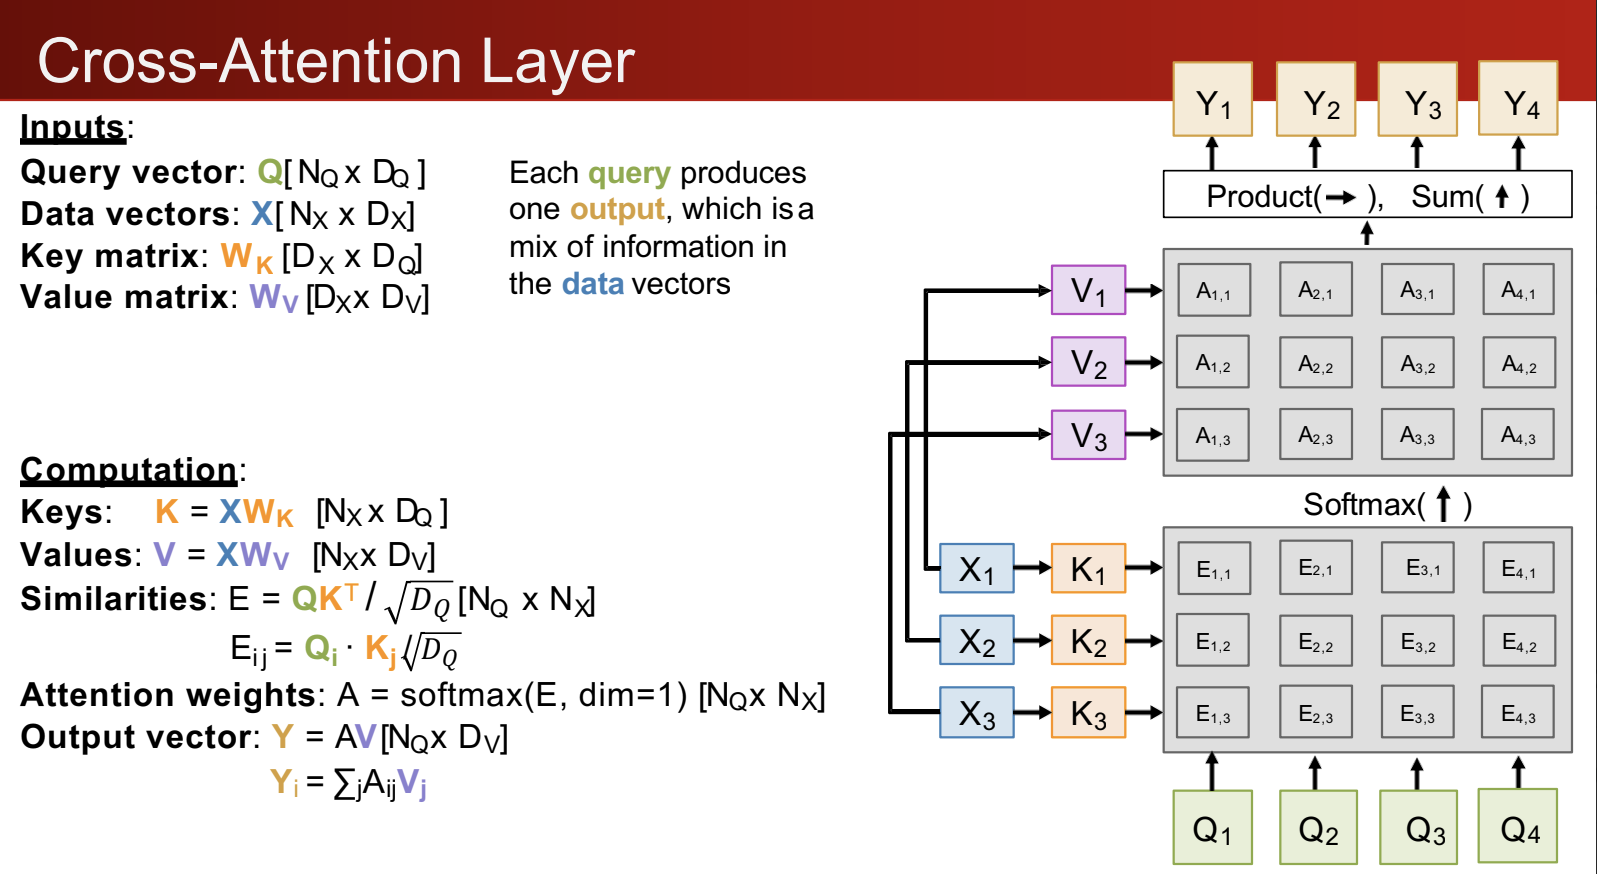
X的顺序变化不影响输出，Q的顺序与Y的输出等变。  
前者不符合实际情况需求，所以引入顺序标签，也就是给每个X的底下加一个它是第几个的分量。
### Self Attention Layer
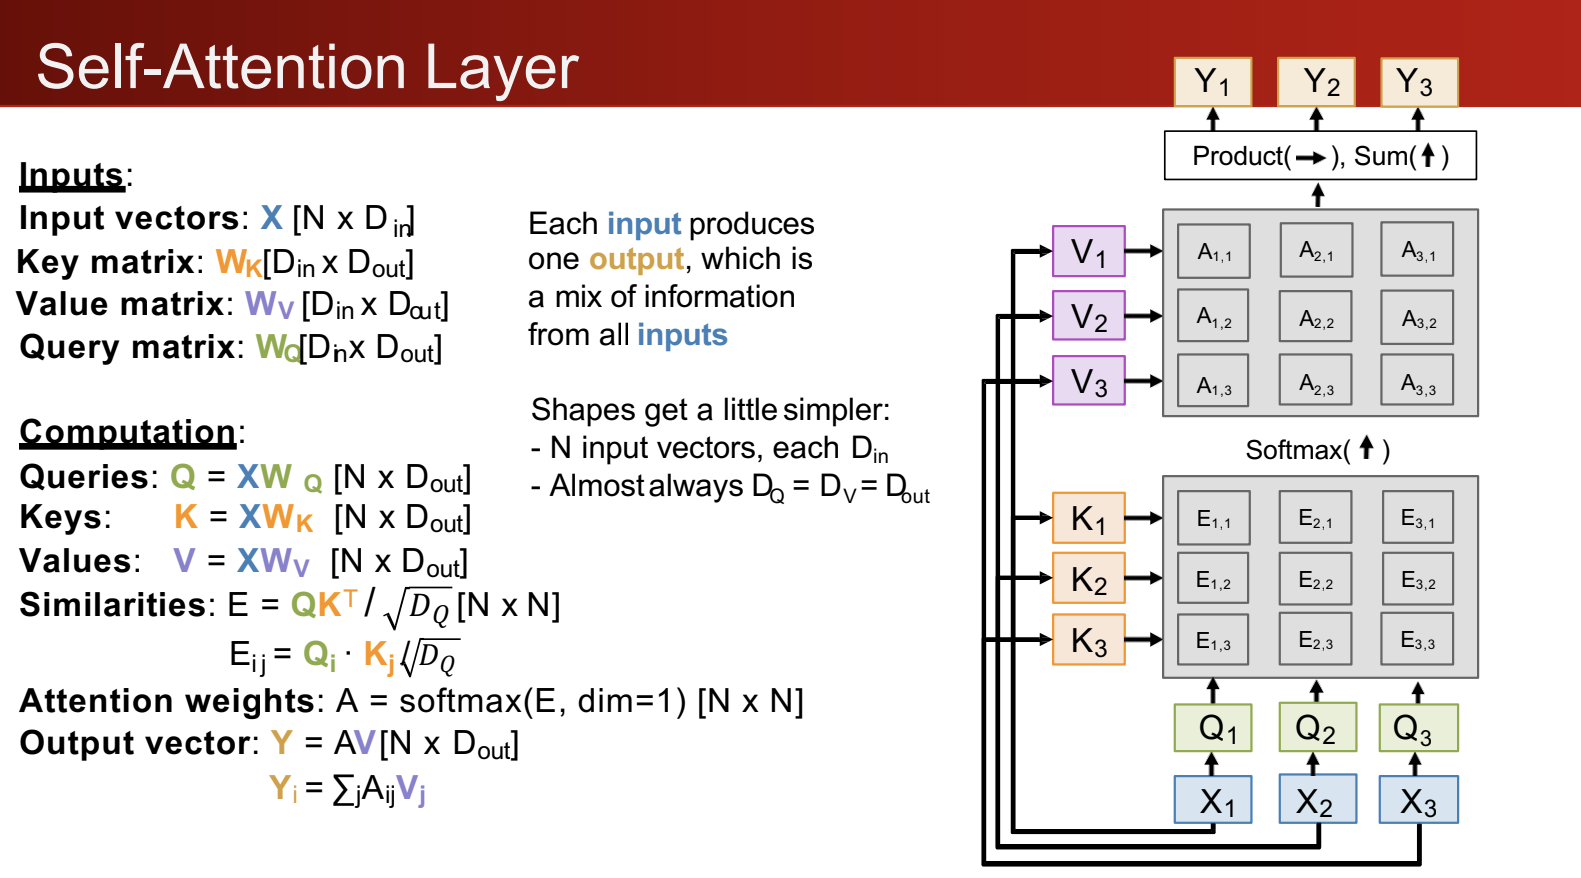

#### 对比 Self-Attention 和 1D Convolution

从宏观上看，**Self-Attention 和 1D Convolution 都在做同一件事**：

**输入一个向量序列，为序列中的每一个向量，通过聚合其“邻居”的信息，来生成一个包含了上下文信息的新向量，并且输出序列的维度和长度通常与输入保持一致。**

*   **输入**: `{x_1, x_2, x_3, ..., x_n}` (比如，一句话里的每个词向量)
*   **输出**: `{y_1, y_2, y_3, ..., y_n}` (每个 `y_i` 是 `x_i` 融合了上下文之后的新表示)

但是，它们实现“上下文聚合”的方式，也就是对“邻居”的定义和使用方式不同：
| 特性 | **一维卷积 (1D Convolution)** | **自注意力 (Self-Attention)** |
| :--- | :--- | :--- |
| **核心机制** | 固定的滑动窗口滤波器 | 动态的全局信息加权 |
| **视野范围** | **局部 (Local)** | **全局 (Global)** |
| **信息交互** | 只与窗口内的邻居交互 | 与序列中**所有**元素直接交互 |
| **权重特性** | **静态的** (与输入内容无关) | **动态的** (根据输入内容实时计算) |
| **擅长任务** | 捕捉局部、固定的模式 (如n-grams) | 捕捉长距离、动态的依赖关系 |

#### 对比 Self-Attention 和 Cross Attention

二者**唯一区别**就在于：**Key (K) 和 Value (V) 的来源不同**。

| 特性 | **Self-Attention (自注意力)** | **Cross-Attention (交叉注意力)** |
| :--- | :--- | :--- |
| **核心思想** | **内部审视 (Introspection)** | **外部对齐 (Alignment)** |
| **做什么？** | 一个序列**内部**的元素之间互相计算注意力，以更好地理解自身的结构和上下文。 | **一个序列**（作为Query）去关注**另一个序列**（作为Key/Value）中的信息，以建立两个序列间的联系和对齐。 |
| **Q, K, V 的来源** | Q, K, V **全部**来自**同一个**输入序列 `X`。 | Q 来自**一个**输入序列 `Y`，而 K 和 V 来自**另一个**输入序列 `X`。 |
| **信息流** | `序列 A`  <--> `序列 A` | `序列 B` --> `序列 A` |
| **比喻** | **开班会**：班级里的每个同学都看看其他所有同学，了解班级内部的动态。 | **请教专家**：一个学生（Query序列）带着问题，去请教一群专家（Key/Value序列），并综合他们的意见。 |
| **典型应用** | Transformer的**编码器**（Encoder）中，用于理解输入句子的内部语法和语义关系。 | Transformer的**解码器**（Decoder）中，用于将输出句子的词与输入句子的词进行对齐（比如机器翻译）。 |

### Masked Self-Attention Layer: 防止模型“预知未来”
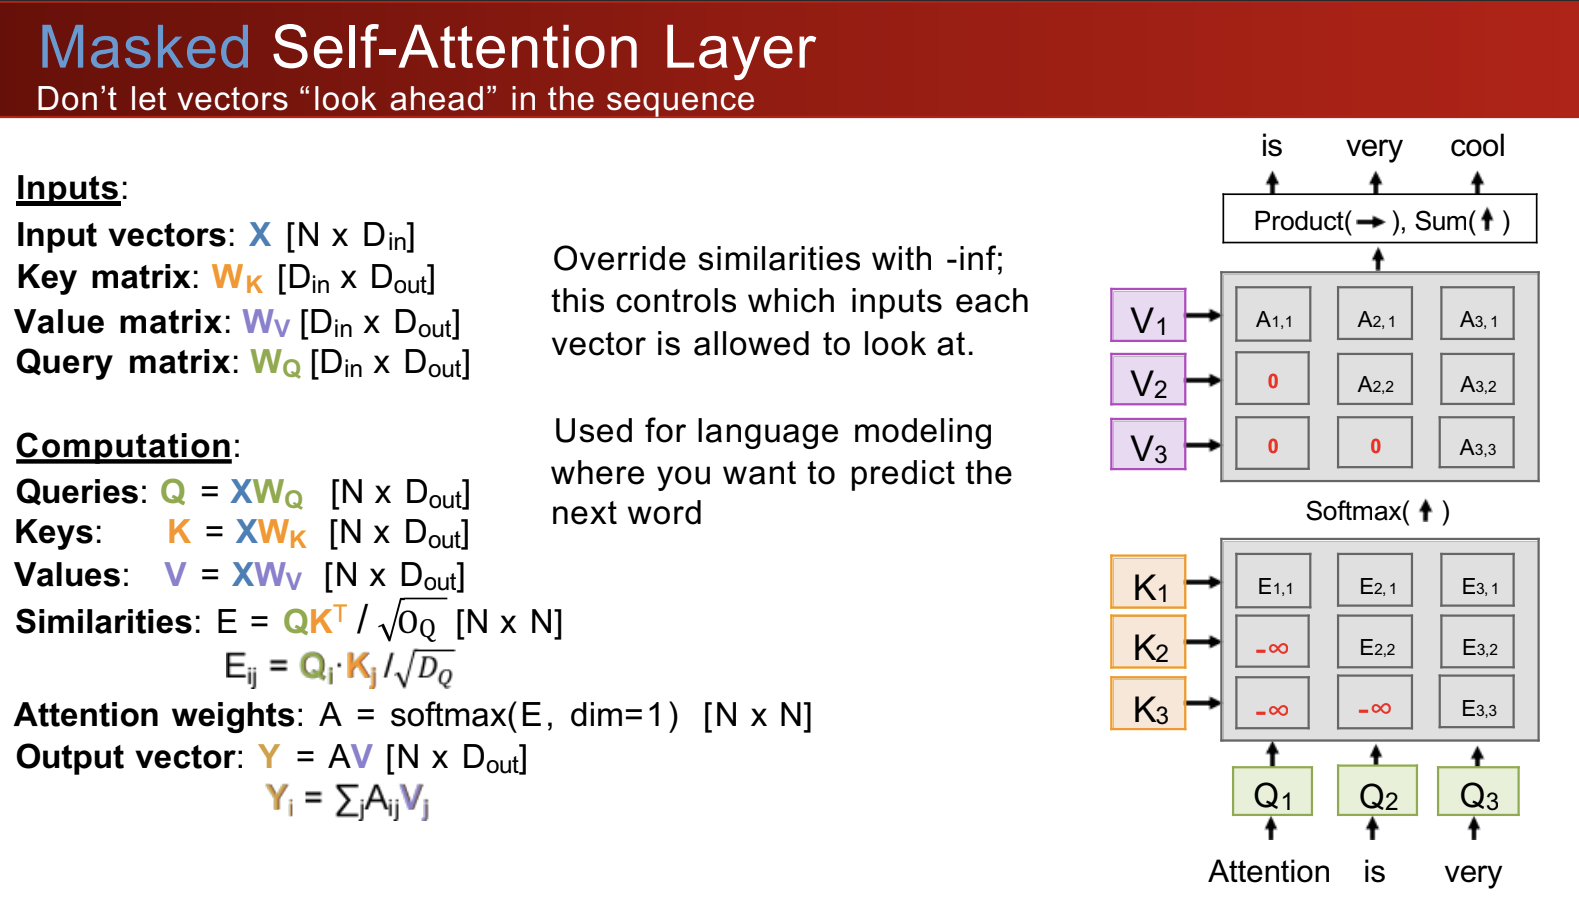

在某些任务中，我们对模型的要求是**自回归 (auto-regressive)** 的，即一次生成一个元素，并且生成当前元素时，只能利用它**之前**已经生成的信息。最典型的例子就是语言模型，它的任务是根据前面的词来预测下一个词。

#### a. 核心问题：训练中的“信息泄露”

在标准的自注意力机制中，序列中的每个词都会关注**所有**其他词（包括它前面和后面的）。如果在训练一个语言模型时也这样做，就会出现一个致命问题：

当模型在第 `t` 个位置尝试预测第 `t+1` 个词时，它的自注意力层已经看到了第 `t+1` 个词（以及之后所有词）的信息。这就像让学生做一道填空题，却把完整的答案印在了旁边。学生不需要学习任何知识，只需学会“抄袭”即可。这样的模型在真实预测时（当未来是未知的时候）将毫无用处。

#### b. 解决方案：引入“遮罩” (Masking)

**掩码自注意力**就是为了解决这个问题而设计的。它的核心思想非常简单：**在计算注意力权重时，强行将所有“未来”位置的权重设置为零。**

这样，在任何一个位置 `t`，模型进行信息聚合时，它的“视线”被限制在了从位置 `0` 到 `t` 的范围内，无法“偷看” `t+1` 及之后的位置。

#### c. 实现机制：如何“遮挡”未来？

这个“遮挡”操作是在计算出**注意力分数矩阵 `E`** 之后，应用 **`softmax` 函数之前**完成的。

1.  **计算原始注意力分数**：和标准自注意力一样，我们首先计算出分数矩阵 `E`。
    
    $E = \frac{QK^T}{\sqrt{d_k}}$
    
2.  **应用遮罩 (Apply Mask)**：我们创建一个“遮罩矩阵”（Mask），通常是一个上三角矩阵。在这个矩阵中，所有需要被遮挡的位置（即代表“未来”的位置）都被赋予一个非常大的负值（例如，负无穷 `-∞`）。
    
    我们将这个遮罩矩阵加到原始分数矩阵上。
    
    $E_{\text{masked}} = E + \text{Mask}$
    
    举个例子，对于一个长度为4的序列，其遮罩后的分数矩阵大概是这样的：
    
    $E_{\text{masked}} = \begin{pmatrix} s_{11} & s_{12} & s_{13} & s_{14} \\ s_{21} & s_{22} & s_{23} & s_{24} \\ s_{31} & s_{32} & s_{33} & s_{34} \\ s_{41} & s_{42} & s_{43} & s_{44} \end{pmatrix} + \begin{pmatrix} 0 & -\infty & -\infty & -\infty \\ 0 & 0 & -\infty & -\infty \\ 0 & 0 & 0 & -\infty \\ 0 & 0 & 0 & 0 \end{pmatrix} = \begin{pmatrix} s_{11} & -\infty & -\infty & -\infty \\ s_{21} & s_{22} & -\infty & -\infty \\ s_{31} & s_{32} & s_{33} & -\infty \\ s_{41} & s_{42} & s_{43} & s_{44} \end{pmatrix}$
    
    *请注意：实际操作中，对角线以上的部分（`j > i`）被设置为负无穷。*
    
3.  **计算 Softmax**：接下来，对这个被修改过的分数矩阵应用 `softmax` 函数。
    
    $A = \text{softmax}(E_{\text{masked}})$
    
    由于 $e^{-\infty}$ 的值趋近于0，所以所有被设置为负无穷的位置，在经过 `softmax` 计算后，其对应的注意力权重会**精确地变成 0**。
    
    最终得到的注意力权重矩阵 `A` 就会是这样的形式：
    
    $A = \begin{pmatrix} w_{11} & 0 & 0 & 0 \\ w_{21} & w_{22} & 0 & 0 \\ w_{31} & w_{32} & w_{33} & 0 \\ w_{41} & w_{42} & w_{43} & w_{44} \end{pmatrix}$
    
    其中，每一行的权重之和为1。
    
4.  **加权求和**：最后，用这个“屏蔽”了未来的权重矩阵 `A` 去对 `Value` 向量 `V` 进行加权求和，得到最终的输出。
    
    $Y = AV$
    

#### d. 应用场景

**掩码自注意力**是所有**自回归生成模型**的核心组件，包括：

*   **Transformer 的解码器 (Decoder)**：在机器翻译等任务中，解码器在生成目标语言的第 `i` 个词时，只能看到自己前面已经生成的 `0` 到 `i-1` 个词。
*   **仅解码器 (Decoder-only) 的大语言模型**：如 **GPT系列** (Generative Pre-trained Transformer)。这类模型整个架构都由掩码自注意力层堆叠而成，其根本任务就是不断地根据前面的文本预测下一个词。

通过这种“自断后路”的方式，模型被迫真正地去“学习”语言的内在规律，而不是“抄袭”训练数据中的答案，从而获得了强大的文本生成和泛化能力。